# Обучение DCGAN
### Пухкало В.

## utils

In [4]:
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results


Random Seed:  999


## Подготовка данных

In [5]:
# Root directory for dataset
dataroot = "/kaggle/input/celeba-dataset/img_align_celeba"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 128

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

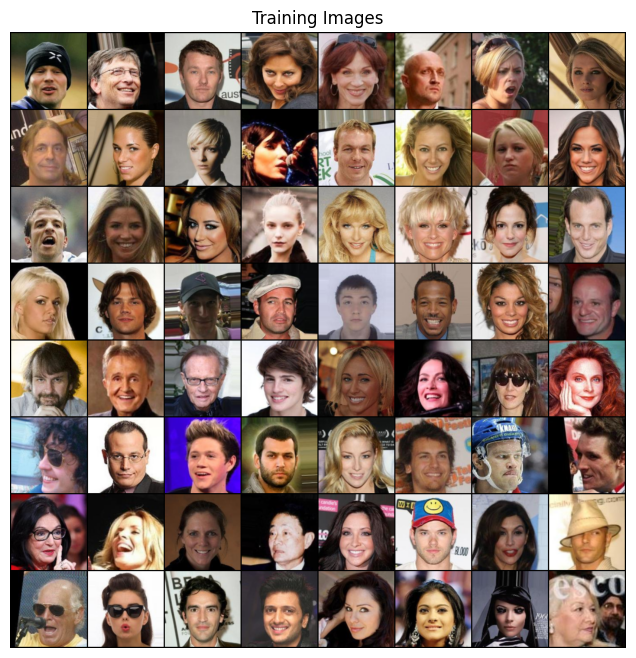

In [6]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [7]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

## Имплементация CSPup блока

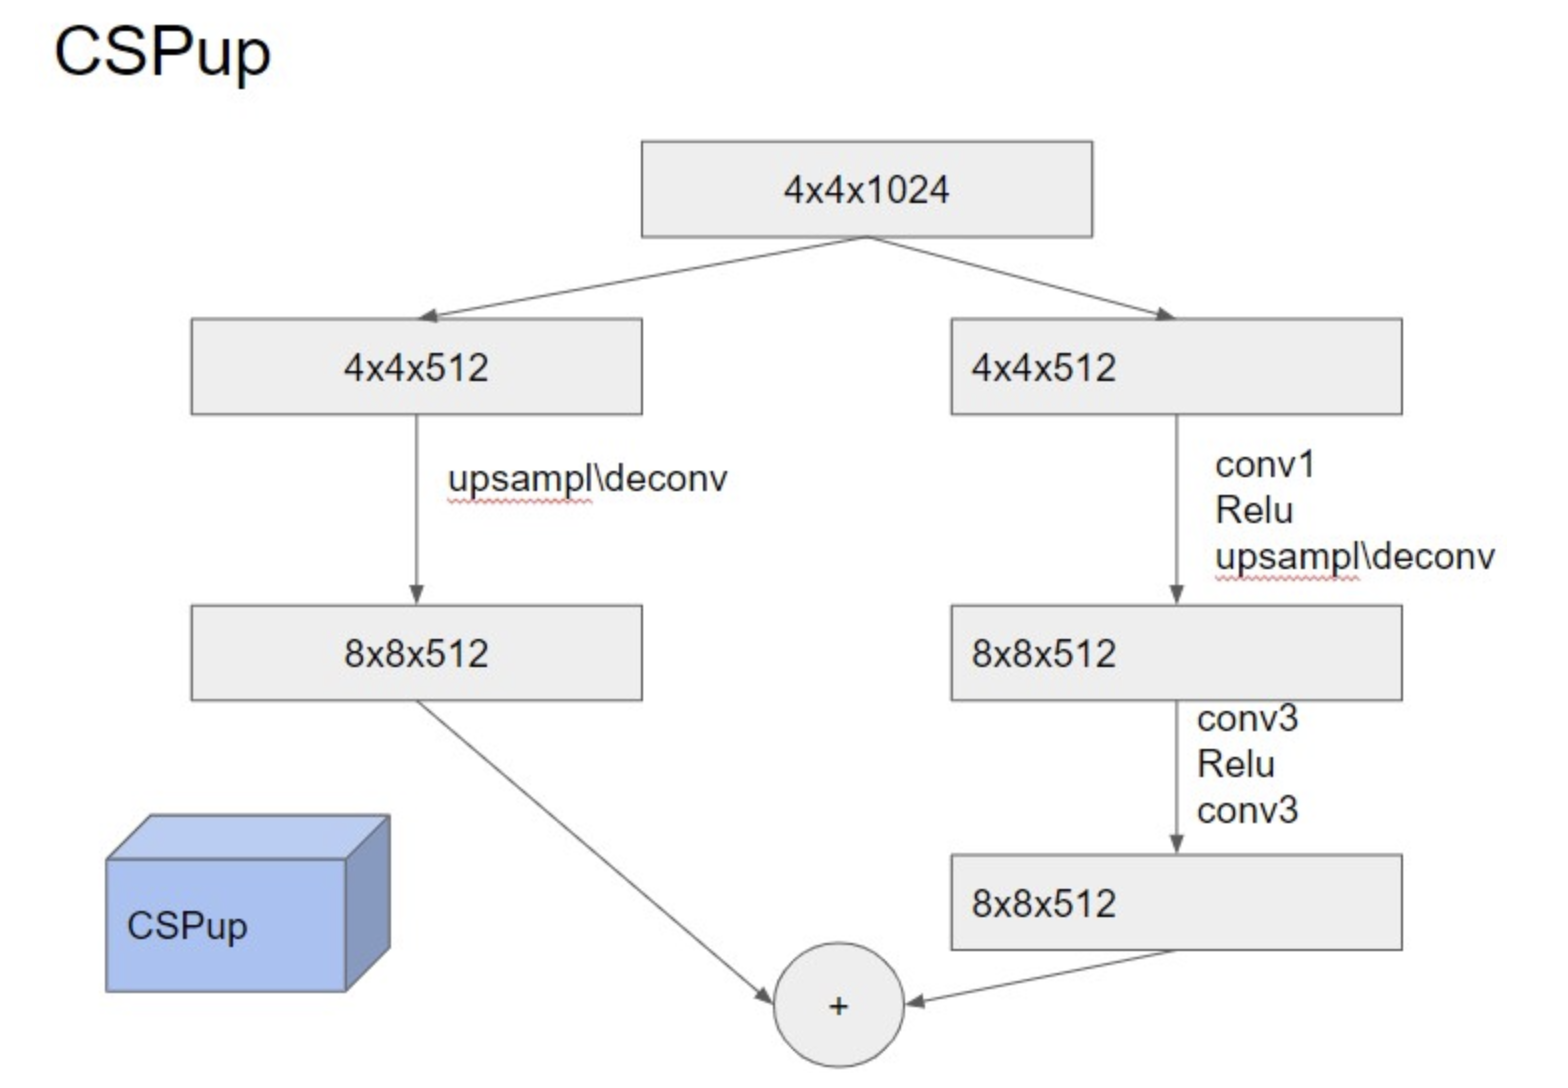

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CSPupBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(CSPupBlock, self).__init__()
        
        # первая ветка
        self.deconv1 = nn.ConvTranspose2d(in_channels // 2, out_channels, kernel_size=4, stride=2, padding=1)
        
        # вторая
        self.conv1 = nn.Conv2d(in_channels // 2, in_channels // 2, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.deconv2 = nn.ConvTranspose2d(in_channels // 2, out_channels, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

    def forward(self, x):
        x1, x2 = torch.split(x, x.size(1) // 2, dim=1) #если x [1, 1024, 4, 4]
        
        x1 = self.deconv1(x1) #[1, 512, 8, 8]
    
        x2 = self.conv1(x2) #[1, 512, 4, 4]
        x2 = self.relu1(x2)
        x2 = self.deconv2(x2) #[1, 512, 8, 8]
        x2 = self.conv2(x2)
        x2 = self.relu2(x2)
        x2 = self.conv3(x2) #[1, 512, 8, 8]
        
        return x1 + x2  

# Пример использования
cspup = CSPupBlock(1024, 512)
input_tensor = torch.randn(1, 1024, 4, 4)
output_tensor = cspup(input_tensor)
print(output_tensor.shape)  # Должно быть [1, 512, 8, 8]

torch.Size([1, 512, 8, 8])


## Архитектура DCGAN

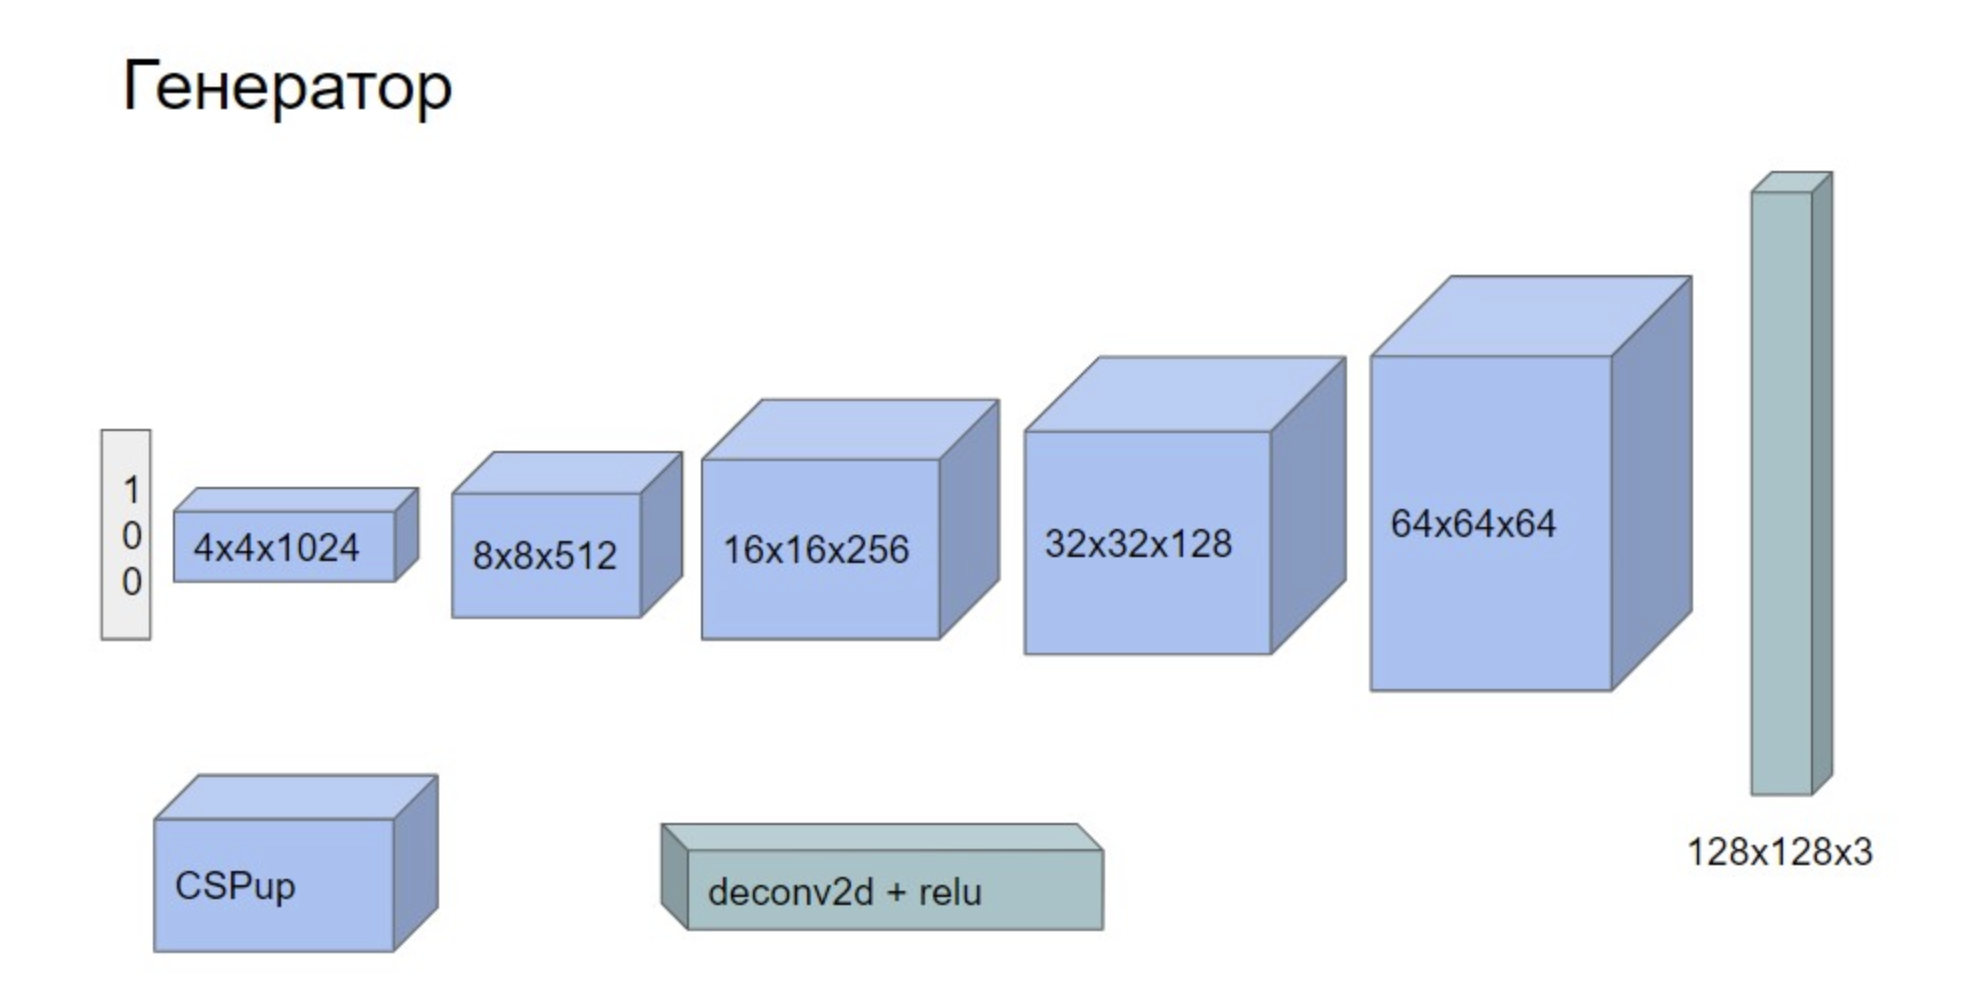

In [9]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.initial = nn.Sequential(
            nn.ConvTranspose2d(100, 1024, kernel_size=4, stride=1, padding=0, bias=False),
            nn.ReLU(True)
        )

        self.cspup1 = CSPupBlock(1024, 512)
        self.cspup2 = CSPupBlock(512, 256)
        self.cspup3 = CSPupBlock(256, 128)
        self.cspup4 = CSPupBlock(128, 64)

        self.final = nn.Sequential(
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.ReLU(True)
        )

    def forward(self, input):
        #print(input.shape)
        x = self.initial(input)
        #print(x.shape)
        x = self.cspup1(x)
        #print(x.shape)
        x = self.cspup2(x)
        #print(x.shape)
        x = self.cspup3(x)
        #print(x.shape)
        x = self.cspup4(x)
        #print(x.shape)
        output = self.final(x)
        return output

In [7]:
# тестим размерности
netG = Generator(ngpu).to("cuda")

latent_vec = torch.randn(1, 100, 1, 1, device="cuda")

# Generate an image
with torch.no_grad():
    fake_image = netG(latent_vec)

print(fake_image.shape)  # Должно быть [1, 3, 128, 128]

torch.Size([1, 3, 128, 128])


In [63]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (initial): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): ReLU(inplace=True)
  )
  (cspup1): CSPupBlock(
    (deconv1): ConvTranspose2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU()
    (deconv2): ConvTranspose2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU()
    (conv3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (cspup2): CSPupBlock(
    (deconv1): ConvTranspose2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU()
    (deconv2): ConvTranspose2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(256, 256, kernel_size=(3,

In [9]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # входы размера 3 x 128 x 128
            nn.Conv2d(3, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 8, ndf * 16, 4, 2, 1, bias=False), 
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 16, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [28]:
# проверяем размерности
netD = Discriminator(ngpu).to("cuda")

input_tensor = torch.randn(1, 3, 128, 128, device="cuda")

with torch.no_grad():
    output = netD(input_tensor)

print(output)

tensor([[[[0.5461]]]], device='cuda:0')


In [29]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): BatchNorm2d(1024, eps=1e-05

## Обучение архитектуры без экспериментов

In [27]:
# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [28]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0
num_epochs = 5

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 200 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/5][0/1583]	Loss_D: 1.4050	Loss_G: 18.7488	D(x): 0.5538	D(G(z)): 0.3201 / 0.0000
[0/5][200/1583]	Loss_D: 0.0000	Loss_G: 61.5787	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[0/5][400/1583]	Loss_D: 0.0000	Loss_G: 60.4465	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[0/5][600/1583]	Loss_D: 0.0000	Loss_G: 59.9736	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[0/5][800/1583]	Loss_D: 0.0000	Loss_G: 57.3314	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[0/5][1000/1583]	Loss_D: 0.0000	Loss_G: 60.7058	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[0/5][1200/1583]	Loss_D: 0.0000	Loss_G: 61.8754	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[0/5][1400/1583]	Loss_D: 0.0000	Loss_G: 61.2382	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[1/5][0/1583]	Loss_D: 0.0000	Loss_G: 60.1082	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[1/5][200/1583]	Loss_D: 0.0000	Loss_G: 59.8830	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[1/5][400/1583]	Loss_D: 0.0000	Loss_G: 59.8755	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[1/5][600/1583]	Loss_D: 0.0046	Loss_G: 7

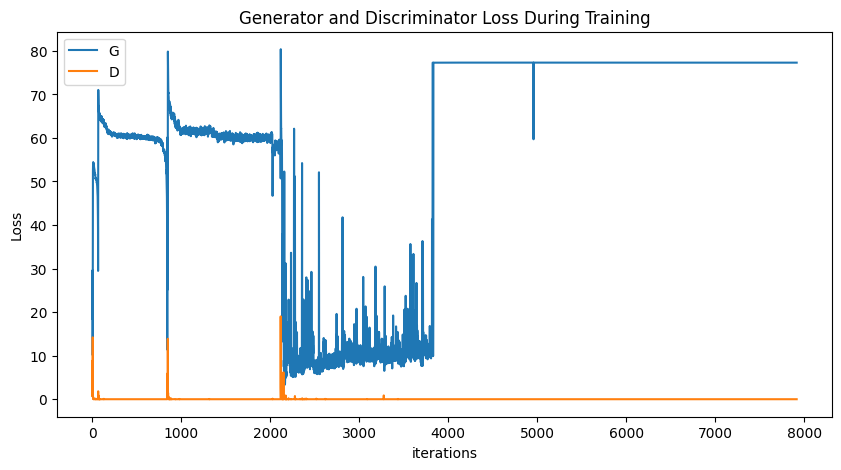

In [29]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

Видно, что без дополнительных усилий сеть вообще ничего не генерирует. Сходимости нет. 

## Эксперименты

### Попробуем обновлять дискриминатор реже, чем генератор. 

In [67]:
# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0
num_epochs = 5
D_updates = 10 #обновляем дискриминатор реже в 10 раз

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        
        if i % D_updates == 0 and epoch < 4:
            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            ## Train with all-real batch
            netD.zero_grad()
            # Forward pass real batch through D
            output = netD(real_cpu).view(-1)
            # Calculate loss on all-real batch
            errD_real = criterion(output, label)
            # Calculate gradients for D in backward pass
            errD_real.backward()
            D_x = output.mean().item()

            ## Train with all-fake batch
            label.fill_(fake_label)
            # Classify all fake batch with D
            output = netD(fake.detach()).view(-1)
            # Calculate D's loss on the all-fake batch
            errD_fake = criterion(output, label)
            # Calculate the gradients for this batch, accumulated (summed) with previous gradients
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            # Compute error of D as sum over the fake and the real batches
            errD = errD_real + errD_fake
            # Update D
            optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 200 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/5][0/1583]	Loss_D: 2.2637	Loss_G: 22.7866	D(x): 0.4343	D(G(z)): 0.5675 / 0.0000
[0/5][200/1583]	Loss_D: 0.0593	Loss_G: 65.5854	D(x): 0.9860	D(G(z)): 0.0000 / 0.0000
[0/5][400/1583]	Loss_D: 0.0001	Loss_G: 64.3446	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[0/5][600/1583]	Loss_D: 0.0133	Loss_G: 64.0173	D(x): 0.9936	D(G(z)): 0.0000 / 0.0000
[0/5][800/1583]	Loss_D: 0.0004	Loss_G: 63.7742	D(x): 0.9996	D(G(z)): 0.0000 / 0.0000
[0/5][1000/1583]	Loss_D: 0.0004	Loss_G: 63.5495	D(x): 0.9996	D(G(z)): 0.0000 / 0.0000
[0/5][1200/1583]	Loss_D: 0.0000	Loss_G: 63.4951	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[0/5][1400/1583]	Loss_D: 0.0000	Loss_G: 63.0903	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[1/5][0/1583]	Loss_D: 0.0000	Loss_G: 63.2925	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[1/5][200/1583]	Loss_D: 0.0000	Loss_G: 63.0644	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[1/5][400/1583]	Loss_D: 0.0000	Loss_G: 63.0008	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[1/5][600/1583]	Loss_D: 0.0001	Loss_G: 6

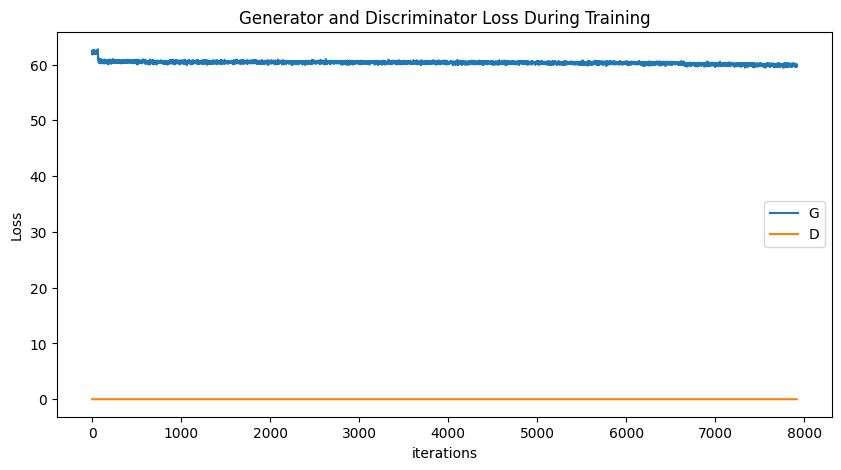

In [54]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

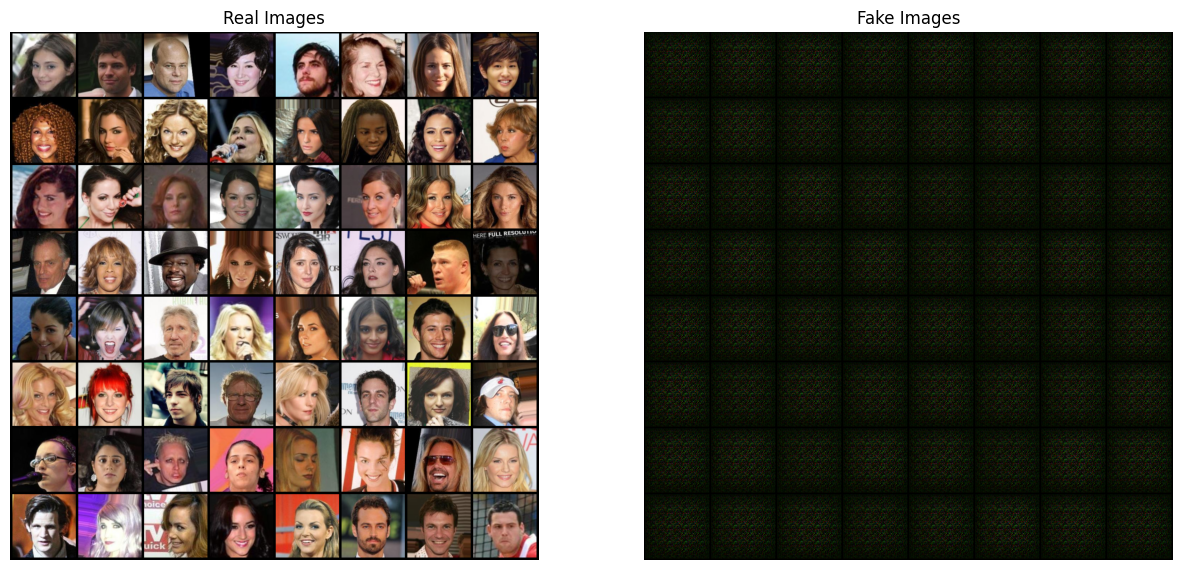

In [57]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

**Не сработало, видим мод коллапс. Варианты, почему:**

1. Архитектура дискриминатора не менялась + там есть батчнорм. Возможно, стоит добавить батчнорм в генератор. 
2. Скорость обучения. Сейчас для обеих сетей задана одна и та же, возможно, стоит поставить разную. 
3. Неподходящие гиперпараметры для адама
4. Неподходящий лосс

### Попробуем добавить батчнорм в генератор

In [13]:
class CSPupBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(CSPupBlock, self).__init__()

        # Первая ветка
        self.deconv1 = nn.ConvTranspose2d(in_channels // 2, out_channels, kernel_size=4, stride=2, padding=1)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)  # BatchNorm после деконволюции

        # Вторая ветка
        self.conv1 = nn.Conv2d(in_channels // 2, in_channels // 2, kernel_size=3, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(in_channels // 2)  # BatchNorm после первой конволюции
        self.relu1 = nn.ReLU()
        self.deconv2 = nn.ConvTranspose2d(in_channels // 2, out_channels, kernel_size=4, stride=2, padding=1)
        self.batch_norm3 = nn.BatchNorm2d(out_channels)  # BatchNorm после второй деконволюции
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.batch_norm4 = nn.BatchNorm2d(out_channels)  # BatchNorm после второй конволюции
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.batch_norm5 = nn.BatchNorm2d(out_channels)  # BatchNorm после третьей конволюции

    def forward(self, x):
        x1, x2 = torch.split(x, x.size(1) // 2, dim=1)  # Разделение входа

        x1 = self.deconv1(x1)
        x1 = self.batch_norm1(x1)

        x2 = self.conv1(x2)
        x2 = self.batch_norm2(x2)
        x2 = self.relu1(x2)
        x2 = self.deconv2(x2)
        x2 = self.batch_norm3(x2)
        x2 = self.conv2(x2)
        x2 = self.batch_norm4(x2)
        x2 = self.relu2(x2)
        x2 = self.conv3(x2)
        x2 = self.batch_norm5(x2)

        return x1 + x2

In [14]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.initial = nn.Sequential(
            nn.ConvTranspose2d(100, 1024, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(True)
        )

        self.cspup1 = CSPupBlock(1024, 512)
        self.cspup2 = CSPupBlock(512, 256)
        self.cspup3 = CSPupBlock(256, 128)
        self.cspup4 = CSPupBlock(128, 64)

        self.final = nn.Sequential(
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(3),
            nn.ReLU(True)
        )

    def forward(self, input):
        x = self.initial(input)
        x = self.cspup1(x)
        x = self.cspup2(x)
        x = self.cspup3(x)
        x = self.cspup4(x)
        output = self.final(x)
        return output

In [32]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (initial): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (cspup1): CSPupBlock(
    (deconv1): ConvTranspose2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (batch_norm1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batch_norm2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (deconv2): ConvTranspose2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (batch_norm3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batch_norm4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=

In [13]:
# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [14]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0
num_epochs = 5
D_updates = 10 #обновляем дискриминатор реже в 10 раз

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        
        if i % D_updates == 0 and epoch < 4:
            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            ## Train with all-real batch
            netD.zero_grad()
            # Forward pass real batch through D
            output = netD(real_cpu).view(-1)
            # Calculate loss on all-real batch
            errD_real = criterion(output, label)
            # Calculate gradients for D in backward pass
            errD_real.backward()
            D_x = output.mean().item()

            ## Train with all-fake batch
            label.fill_(fake_label)
            # Classify all fake batch with D
            output = netD(fake.detach()).view(-1)
            # Calculate D's loss on the all-fake batch
            errD_fake = criterion(output, label)
            # Calculate the gradients for this batch, accumulated (summed) with previous gradients
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            # Compute error of D as sum over the fake and the real batches
            errD = errD_real + errD_fake
            # Update D
            optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 200 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/5][0/1583]	Loss_D: 1.6522	Loss_G: 17.7626	D(x): 0.6513	D(G(z)): 0.5713 / 0.0000
[0/5][200/1583]	Loss_D: 0.0157	Loss_G: 67.8244	D(x): 0.9928	D(G(z)): 0.0000 / 0.0000
[0/5][400/1583]	Loss_D: 0.0002	Loss_G: 67.0016	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000
[0/5][600/1583]	Loss_D: 0.0002	Loss_G: 66.0899	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000
[0/5][800/1583]	Loss_D: 0.0000	Loss_G: 65.8176	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[0/5][1000/1583]	Loss_D: 0.0017	Loss_G: 65.5985	D(x): 0.9984	D(G(z)): 0.0000 / 0.0000
[0/5][1200/1583]	Loss_D: 0.0019	Loss_G: 65.1454	D(x): 0.9983	D(G(z)): 0.0000 / 0.0000
[0/5][1400/1583]	Loss_D: 0.0000	Loss_G: 64.7824	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[1/5][0/1583]	Loss_D: 0.0000	Loss_G: 65.2817	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[1/5][200/1583]	Loss_D: 0.0000	Loss_G: 64.8121	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[1/5][400/1583]	Loss_D: 0.0001	Loss_G: 64.6673	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[1/5][600/1583]	Loss_D: 0.0000	Loss_G: 6

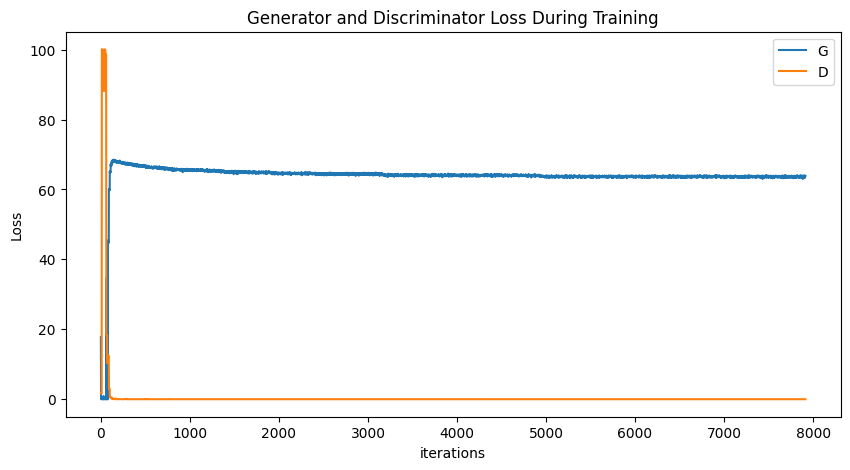

In [15]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

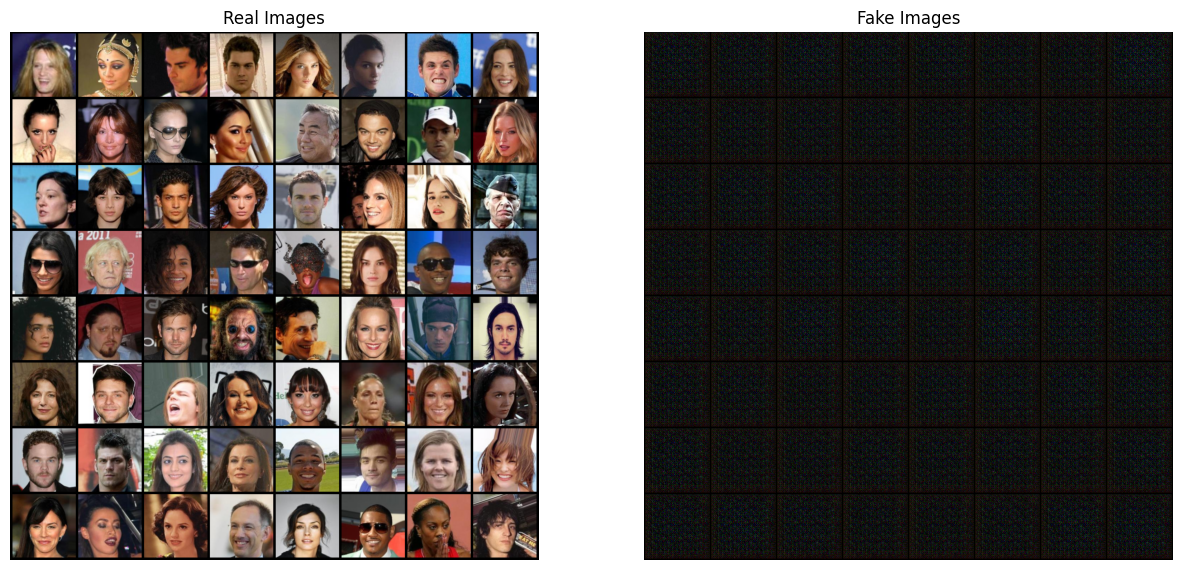

In [16]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

Провал. Судя по тому, что уже на 1 эпохе на 400 итерации лосс дискриминатора близок к нулю, есть гипотеза он просто обучается гораздо гораздо быстрее, и батчнорм тут не поможет. Дискриминатор становится слишком сильным и быстро научается отличать все сгенерированные изображения от реальных, что не оставляет генератору пространства для обучения

Попробуем поставить разный lr для дискриминатора и генератора и посмотрим, что из этого выйдет. 

### Попробуем поставить разный lr для дискриминатора и генератора

In [11]:
lr_D = 0.000068  # Меньше для дискриминатора
lr_G = 0.0002   # Больше для генератора

In [78]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): BatchNorm2d(1024, eps=1e-05

In [79]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (initial): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (cspup1): CSPupBlock(
    (deconv1): ConvTranspose2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (batch_norm1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batch_norm2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (deconv2): ConvTranspose2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (batch_norm3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batch_norm4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=

In [80]:
# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr_D, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr_G, betas=(beta1, 0.999))

In [81]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0
num_epochs = 5
D_updates = 2 #обновляем дискриминатор реже в 10 раз

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        
        if i % D_updates == 0 and epoch < 4:
            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            ## Train with all-real batch
            netD.zero_grad()
            # Forward pass real batch through D
            output = netD(real_cpu).view(-1)
            # Calculate loss on all-real batch
            errD_real = criterion(output, label)
            # Calculate gradients for D in backward pass
            errD_real.backward()
            D_x = output.mean().item()

            ## Train with all-fake batch
            label.fill_(fake_label)
            # Classify all fake batch with D
            output = netD(fake.detach()).view(-1)
            # Calculate D's loss on the all-fake batch
            errD_fake = criterion(output, label)
            # Calculate the gradients for this batch, accumulated (summed) with previous gradients
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            # Compute error of D as sum over the fake and the real batches
            errD = errD_real + errD_fake
            # Update D
            optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 200 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/5][0/1583]	Loss_D: 1.3831	Loss_G: 42.7689	D(x): 0.6254	D(G(z)): 0.4325 / 0.0000
[0/5][200/1583]	Loss_D: 0.0029	Loss_G: 6.0567	D(x): 1.0000	D(G(z)): 0.0029 / 0.0025
[0/5][400/1583]	Loss_D: 0.0005	Loss_G: 9.3827	D(x): 1.0000	D(G(z)): 0.0004 / 0.0004
[0/5][600/1583]	Loss_D: 0.0004	Loss_G: 8.6766	D(x): 1.0000	D(G(z)): 0.0004 / 0.0004
[0/5][800/1583]	Loss_D: 0.0001	Loss_G: 11.0062	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[0/5][1000/1583]	Loss_D: 0.0000	Loss_G: 27.7725	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[0/5][1200/1583]	Loss_D: 0.0002	Loss_G: 9.4735	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002
[0/5][1400/1583]	Loss_D: 0.0001	Loss_G: 10.7102	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[1/5][0/1583]	Loss_D: 0.0000	Loss_G: 11.0646	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[1/5][200/1583]	Loss_D: 0.0001	Loss_G: 10.5767	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[1/5][400/1583]	Loss_D: 0.0000	Loss_G: 10.5601	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[1/5][600/1583]	Loss_D: 0.0000	Loss_G: 10.88

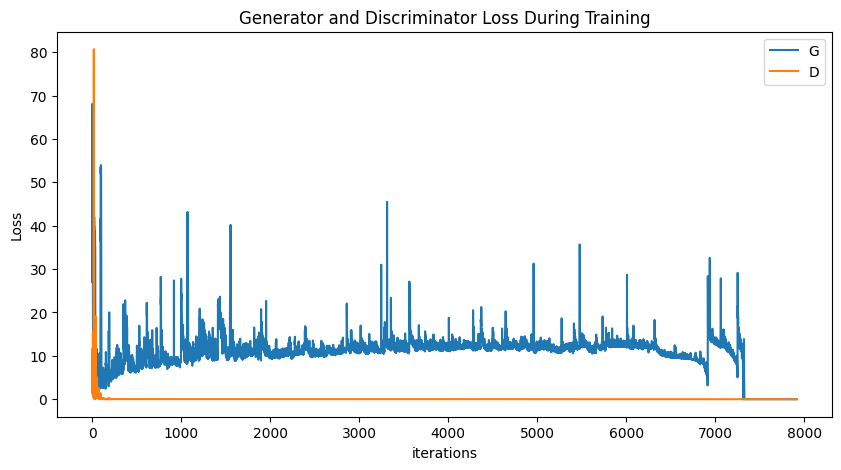

In [82]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

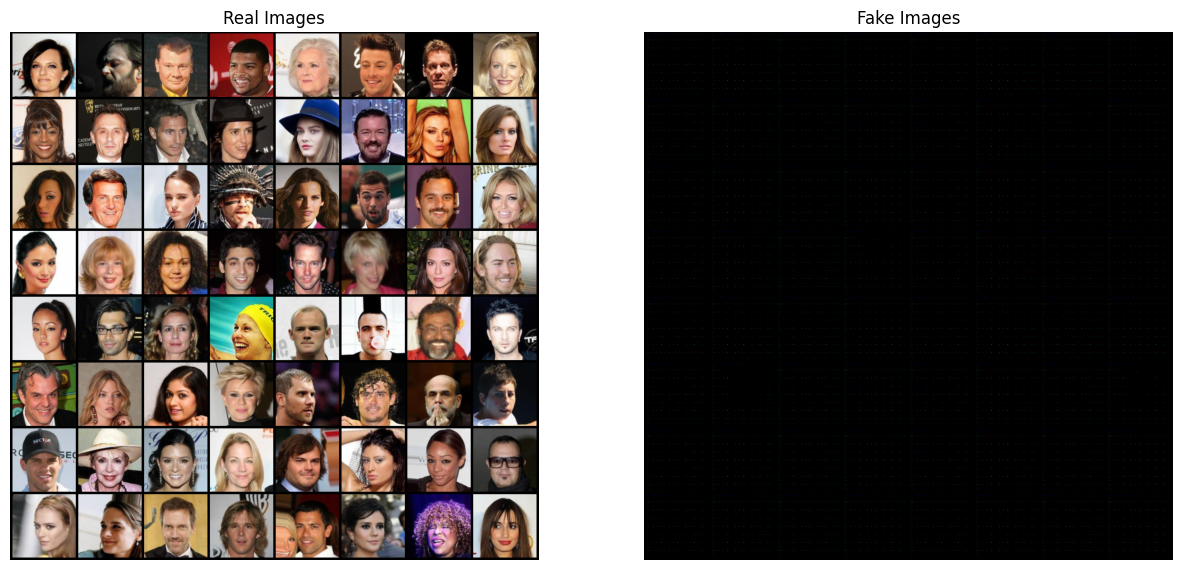

In [86]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

Не сработало даже с долгим и мучительным подбором скоростей и частоты обучения дискриминатора...

### Пробуем wgan

In [31]:
lr_D = 0.00005  # Меньше для дискриминатора
lr_G = 0.0002   # Больше для генератора

In [32]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): BatchNorm2d(1024, eps=1e-05

In [33]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (initial): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (cspup1): CSPupBlock(
    (deconv1): ConvTranspose2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (batch_norm1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batch_norm2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (deconv2): ConvTranspose2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (batch_norm3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batch_norm4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=

In [34]:
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr_D, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr_G, betas=(beta1, 0.999))

In [35]:
# Training Loop

# Lists to keep track of progress
G_losses = []
D_losses = []
img_list = []
iters = 0
num_epochs = 5
D_updates = 2 # Update D less frequently

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)

        netD.zero_grad()

        # Forward pass real batch through D
        output_real = netD(real_cpu).view(-1)
        # Calculate WGAN loss for real images
        errD_real = -torch.mean(output_real)

        # Generate fake image batch with G
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        # Classify all fake batch with D
        output_fake = netD(fake.detach()).view(-1)
        # Calculate WGAN loss for fake images
        errD_fake = torch.mean(output_fake)

        # Total discriminator loss
        errD = errD_real + errD_fake
        # Update D
        errD.backward()
        optimizerD.step()

        D_x = output_real.mean().item()
        D_G_z1 = output_fake.mean().item()

        # Train generator
        netG.zero_grad()
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output_fake = netD(fake).view(-1)
        # Calculate WGAN loss for fake images from the generator
        errG = -torch.mean(output_fake)
        # Update G
        errG.backward()
        optimizerG.step()

        D_G_z2 = output_fake.mean().item()

        # Output training stats
        if i % 200 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/5][0/1583]	Loss_D: 0.1064	Loss_G: -0.1080	D(x): 0.4491	D(G(z)): 0.5555 / 0.1080
[0/5][200/1583]	Loss_D: 0.0000	Loss_G: -1.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[0/5][400/1583]	Loss_D: 0.0000	Loss_G: -1.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[0/5][600/1583]	Loss_D: 0.0000	Loss_G: -1.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[0/5][800/1583]	Loss_D: 0.0000	Loss_G: -1.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[0/5][1000/1583]	Loss_D: 0.0000	Loss_G: -1.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[0/5][1200/1583]	Loss_D: 0.0000	Loss_G: -1.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[0/5][1400/1583]	Loss_D: 0.0000	Loss_G: -1.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[1/5][0/1583]	Loss_D: 0.0000	Loss_G: -1.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[1/5][200/1583]	Loss_D: 0.0000	Loss_G: -1.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[1/5][400/1583]	Loss_D: 0.0000	Loss_G: -1.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[1/5][600/1583]	Loss_D: 0.0000	Loss_G: -

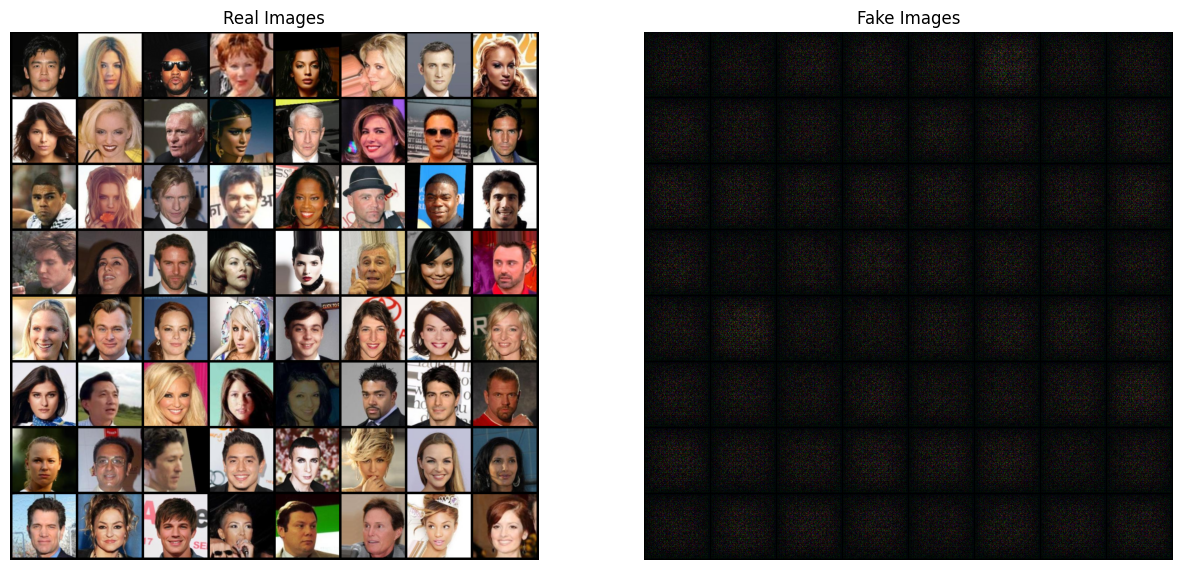

In [37]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

### R2 для генератора + слои с 4х4х512 + учим подольше

In [11]:
class CSPupBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(CSPupBlock, self).__init__()

        # Первая ветка
        self.deconv1 = nn.ConvTranspose2d(in_channels // 2, out_channels, kernel_size=4, stride=2, padding=1)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)  # BatchNorm после деконволюции

        # Вторая ветка
        self.conv1 = nn.Conv2d(in_channels // 2, in_channels // 2, kernel_size=3, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(in_channels // 2)  # BatchNorm после первой конволюции
        self.relu1 = nn.ReLU()
        self.deconv2 = nn.ConvTranspose2d(in_channels // 2, out_channels, kernel_size=4, stride=2, padding=1)
        self.batch_norm3 = nn.BatchNorm2d(out_channels)  # BatchNorm после второй деконволюции
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.batch_norm4 = nn.BatchNorm2d(out_channels)  # BatchNorm после второй конволюции
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.batch_norm5 = nn.BatchNorm2d(out_channels)  # BatchNorm после третьей конволюции

    def forward(self, x):
        x1, x2 = torch.split(x, x.size(1) // 2, dim=1)  # Разделение входа

        x1 = self.deconv1(x1)
        x1 = self.batch_norm1(x1)

        x2 = self.conv1(x2)
        x2 = self.batch_norm2(x2)
        x2 = self.relu1(x2)
        x2 = self.deconv2(x2)
        x2 = self.batch_norm3(x2)
        x2 = self.conv2(x2)
        x2 = self.batch_norm4(x2)
        x2 = self.relu2(x2)
        x2 = self.conv3(x2)
        x2 = self.batch_norm5(x2)

        return x1 + x2

In [12]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.initial = nn.Sequential(
            nn.ConvTranspose2d(100, 512, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True)
        )

        self.cspup1 = CSPupBlock(512, 256)
        self.cspup2 = CSPupBlock(256, 128)
        self.cspup3 = CSPupBlock(128, 64)
        self.cspup4 = CSPupBlock(64, 32)

        self.final = nn.Sequential(
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(3),
            nn.ReLU(True)
        )

    def forward(self, input):
        x = self.initial(input)
        x = self.cspup1(x)
        x = self.cspup2(x)
        x = self.cspup3(x)
        x = self.cspup4(x)
        output = self.final(x)
        return output

In [13]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # входы размера 3 x 128 x 128
            nn.Conv2d(3, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 8, ndf * 16, 4, 2, 1, bias=False), 
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 16, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [34]:
lr_D = 0.000045  # Меньше для дискриминатора
lr_G = 0.0002   # Больше для генератора

In [35]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): BatchNorm2d(1024, eps=1e-05

In [36]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (initial): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (cspup1): CSPupBlock(
    (deconv1): ConvTranspose2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (batch_norm1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batch_norm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (deconv2): ConvTranspose2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (batch_norm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batch_norm4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=Tr

In [37]:
# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr_D, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr_G, betas=(beta1, 0.999), weight_decay=1e-5)

In [38]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0
num_epochs = 7
D_updates = 2 #обновляем дискриминатор реже в 10 раз

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        
        if i % D_updates == 0 and epoch < 4:
            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            ## Train with all-real batch
            netD.zero_grad()
            # Forward pass real batch through D
            output = netD(real_cpu).view(-1)
            # Calculate loss on all-real batch
            errD_real = criterion(output, label)
            # Calculate gradients for D in backward pass
            errD_real.backward()
            D_x = output.mean().item()

            ## Train with all-fake batch
            label.fill_(fake_label)
            # Classify all fake batch with D
            output = netD(fake.detach()).view(-1)
            # Calculate D's loss on the all-fake batch
            errD_fake = criterion(output, label)
            # Calculate the gradients for this batch, accumulated (summed) with previous gradients
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            # Compute error of D as sum over the fake and the real batches
            errD = errD_real + errD_fake
            # Update D
            optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 200 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/7][0/1583]	Loss_D: 2.3626	Loss_G: 2.3290	D(x): 0.3937	D(G(z)): 0.5418 / 0.1490
[0/7][200/1583]	Loss_D: 6.3945	Loss_G: 16.2315	D(x): 0.5046	D(G(z)): 0.9651 / 0.0000
[0/7][400/1583]	Loss_D: 0.8362	Loss_G: 5.6526	D(x): 0.8889	D(G(z)): 0.2002 / 0.0036
[0/7][600/1583]	Loss_D: 0.1366	Loss_G: 4.7593	D(x): 0.9910	D(G(z)): 0.0767 / 0.0087
[0/7][800/1583]	Loss_D: 0.0544	Loss_G: 5.5495	D(x): 0.9913	D(G(z)): 0.0060 / 0.0039
[0/7][1000/1583]	Loss_D: 0.1463	Loss_G: 5.8798	D(x): 0.9825	D(G(z)): 0.0038 / 0.0028
[0/7][1200/1583]	Loss_D: 0.0037	Loss_G: 6.2520	D(x): 0.9988	D(G(z)): 0.0024 / 0.0019
[0/7][1400/1583]	Loss_D: 0.0029	Loss_G: 6.1127	D(x): 1.0000	D(G(z)): 0.0028 / 0.0022
[1/7][0/1583]	Loss_D: 0.0032	Loss_G: 6.6602	D(x): 0.9984	D(G(z)): 0.0015 / 0.0013
[1/7][200/1583]	Loss_D: 0.0008	Loss_G: 7.2639	D(x): 1.0000	D(G(z)): 0.0008 / 0.0007
[1/7][400/1583]	Loss_D: 0.0014	Loss_G: 7.1911	D(x): 0.9995	D(G(z)): 0.0008 / 0.0008
[1/7][600/1583]	Loss_D: 0.0006	Loss_G: 7.5603	D(x)

In [39]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()